In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import time
#import pydotplus

## Predict Default Probability of Recent Loans
We want to try different models to predict loans that are issued since 2014

In [2]:
df1 = pd.read_excel('2014.xlsx',sheetname='Sheet1')
df2 = pd.read_excel('2015.xlsx',sheetname='Sheet1')
df3 = pd.read_excel('2016_Q1.xlsx',sheetname='Sheet1')
df4 = pd.read_excel('2016_Q2.xlsx',sheetname='Sheet1')
df5 = pd.read_excel('2016_Q3.xlsx',sheetname='Sheet1')
df6 = pd.read_excel('2016_Q4.xlsx',sheetname='Sheet1')
df7 = pd.read_excel('2017_Q1.xlsx',sheetname='Sheet1')
df8 = pd.read_excel('2017_Q2.xlsx',sheetname='Sheet1')
df9 = pd.read_excel('2017_Q3.xlsx',sheetname='Sheet1')


In [3]:
date_before_36 = datetime.date(2014,10,1)
date_before_60 = datetime.date(2012,10,1)
df1 = df1[((df1.term.str.contains('36')) & (df1.issue_d > date_before_36))
                | (df1.term.str.contains('60'))]

In [4]:
data_train = pd.concat([df1,df2,df3,df4,df5],join='inner')
data_test = pd.concat([df6,df7,df8],join='inner')

data_train = data_train[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti',
        'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
        'last_pymnt_amnt','last_fico_range_high','last_fico_range_low','application_type',
             'revol_bal','revol_util']]

data_test = data_test[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti',
        'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
        'last_pymnt_amnt','last_fico_range_high','last_fico_range_low','application_type',
             'revol_bal','revol_util']]

data_train.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                          'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs',
                          'grade','last_fico_range_high','last_fico_range_low','installment',
                         'funded_amnt','dti','funded_amnt_inv','revol_bal']
            ,inplace=True)

data_test.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                          'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs',
                          'grade','last_fico_range_high','last_fico_range_low','installment',
                         'funded_amnt','dti','funded_amnt_inv','revol_bal']
            ,inplace=True)

print(data_train.shape)
print(data_test.shape)

(847670, 32)
(305293, 32)


## Feature Extraction
Now we want to use the following set of features for prediction model.
loan_amnt, funded amnt (investor), term (category), int_rate, installment, grade (category), emp_length (category), home_ownership (category), annual_inc, verification_status (category), purpose (category), dti, delinq_2yrs, earliest_cr_line (up to issue_d), open_acc, pub_rec, fico_high, fico_low

In [5]:
# create labels for the dataset
data_train['label'] = (data_train.loan_status.str.contains('Charged Off') | 
                data_train.loan_status.str.contains('Default') | 
                data_train.loan_status.str.contains('Late'))
data_train['cr_hist'] = (data_train.issue_d - data_train.earliest_cr_line) / np.timedelta64(1, 'M')
data_train.label = data_train.label.astype(int)

data_test['label'] = (data_test.loan_status.str.contains('Charged Off') | 
                data_test.loan_status.str.contains('Default') | 
                data_test.loan_status.str.contains('Late'))
data_test['cr_hist'] = (data_test.issue_d - data_test.earliest_cr_line) / np.timedelta64(1, 'M')
data_test.label = data_test.label.astype(int)


# clean and get training/testing data 
temp = pd.get_dummies(data_train[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
X_train = data_train.as_matrix(columns=['loan_amnt','funded_amnt_inv','int_rate','installment',
                                       'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                                       'last_fico_range_high','last_fico_range_low','cr_hist'])
X_train = np.concatenate((X_train,temp.as_matrix()),axis=1)
y_train = data_train.label.as_matrix()

temp = pd.get_dummies(data_test[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
X_test = data_test.as_matrix(columns=['loan_amnt','funded_amnt_inv','int_rate','installment',
                                       'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                                       'last_fico_range_high','last_fico_range_low','cr_hist'])
X_test = np.concatenate((X_test,temp.as_matrix()),axis=1)
y_test = data_test.label.as_matrix()

print(X_train.shape)
print(X_test.shape)

(847670, 60)
(305293, 60)


In [6]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

## Prediction of Default
### Logistic Regression with cross-validation

In [25]:
from sklearn.linear_model import LogisticRegressionCV

time_start = time.clock()
logisticModel = LogisticRegressionCV(cv=10)
logisticModel.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)

computation time:  3025.089366


In [17]:
np.argsort(logisticModel.coef_)

array([[ 9,  4,  6,  2, 59,  0, 36,  1, 16, 15, 17, 46, 45, 35, 22, 49, 38,
        41, 60, 14, 31, 29, 27, 24, 28, 32, 26, 30, 25, 51, 23, 33, 52, 55,
        50, 18, 54, 47, 58, 48, 12, 53, 19, 44, 42, 43, 57, 37, 20, 39, 21,
        40, 34, 56, 10, 13,  7, 11,  8,  3,  5]])

In [33]:
print(logisticModel.coef_[0,6])
print(logisticModel.coef_[0,8])

-3.84946890517
3.12741998481


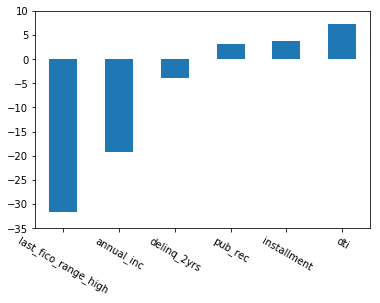

In [51]:
bplot = pd.Series(logisticModel.coef_[0,[9,4,6,8,3,5]])
xticks = ['last_fico_range_high','annual_inc','delinq_2yrs','pub_rec','installment','dti']
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-35,10))
p1.set_xticklabels(xticks)
plt.show()

In [26]:
y_pred = logisticModel.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.97055287871
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9749    0.9950    0.9849    293742
    Defaulted Loan     0.7334    0.3484    0.4724     11551

       avg / total     0.9658    0.9706    0.9655    305293

AUC:  0.671693772742


### Support Vector Machine

In [10]:
from sklearn.svm import SVC
svcModel = SVC(kernel='rbf')
svcModel.fit(X_train_minmax,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
y_pred = svcModel.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.941154532234
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9582    0.9763    0.9671    306878
    Defaulted Loan     0.7808    0.6649    0.7182     39011

       avg / total     0.9382    0.9412    0.9391    345889

AUC:  0.820570487016


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

time_start = time.clock()
rf_Gini = RandomForestClassifier(max_depth=10)
rf_Gini.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)

computation time:  17.96470899999997


In [18]:
y_pred = rf_Gini.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.969632451448
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9786    0.9901    0.9843    293742
    Defaulted Loan     0.6408    0.4492    0.5282     11551

       avg / total     0.9658    0.9696    0.9671    305293

AUC:  0.71966096344


In [19]:
rf_Entro = RandomForestClassifier(criterion='entropy',max_depth=10)
rf_Entro.fit(X_train_minmax,y_train)
y_pred = rf_Entro.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.969242661967
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9792    0.9890    0.9841    293742
    Defaulted Loan     0.6257    0.4658    0.5340     11551

       avg / total     0.9658    0.9692    0.9671    305293

AUC:  0.727400971947


### Decision Trees

In [20]:
from sklearn.tree import DecisionTreeClassifier

tree_Gini = DecisionTreeClassifier(max_depth=10)
time_start = time.clock()
tree_Gini.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)
y_pred = tree_Gini.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

computation time:  10.450222000000053
accuracy:  0.969288519553
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9785    0.9898    0.9841    293742
    Defaulted Loan     0.6333    0.4472    0.5243     11551

       avg / total     0.9655    0.9693    0.9667    305293

AUC:  0.718525800373


In [21]:
tree_Entro = DecisionTreeClassifier(max_depth=8,criterion='entropy')
tree_Entro.fit(X_train_minmax,y_train)
y_pred = tree_Gini.predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.969288519553
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9785    0.9898    0.9841    293742
    Defaulted Loan     0.6333    0.4472    0.5243     11551

       avg / total     0.9655    0.9693    0.9667    305293

AUC:  0.718525800373


### Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb = GaussianNB()
time_start = time.clock()
y_pred = gnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

computation time:  1.880553999999961
accuracy:  0.636879980871
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9646    0.6463    0.7740    293742
    Defaulted Loan     0.0422    0.3967    0.0764     11551

       avg / total     0.9297    0.6369    0.7476    305293

AUC:  0.521500649834


In [23]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.568408053902
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9757    0.5655    0.7160    293742
    Defaulted Loan     0.0549    0.6418    0.1011     11551

       avg / total     0.9409    0.5684    0.6928    305293

AUC:  0.603643052276


In [24]:
bnb = BernoulliNB()
y_pred = bnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,y_pred))

accuracy:  0.596567887243
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9754    0.5958    0.7397    293742
    Defaulted Loan     0.0566    0.6173    0.1038     11551

       avg / total     0.9406    0.5966    0.7156    305293

AUC:  0.606508335901


## Prediction of Early Repayment

In [57]:
from statsmodels.regression.linear_model import OLS

data['duration'] = (data.last_pymnt_d - data.issue_d) / np.timedelta64(1, 'M')
data_early = data[data.loan_status.str.contains('Paid')]
print(data_early.shape)

(298184, 35)
